# SARIMAX MODEL

### SETUP

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [25, 12]

In [3]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)tuples
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                           exog,
                           order=(param[0], d, param[1]),
                           seasonal_order=(param[2], D, param[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### DATA PREPROCESSING

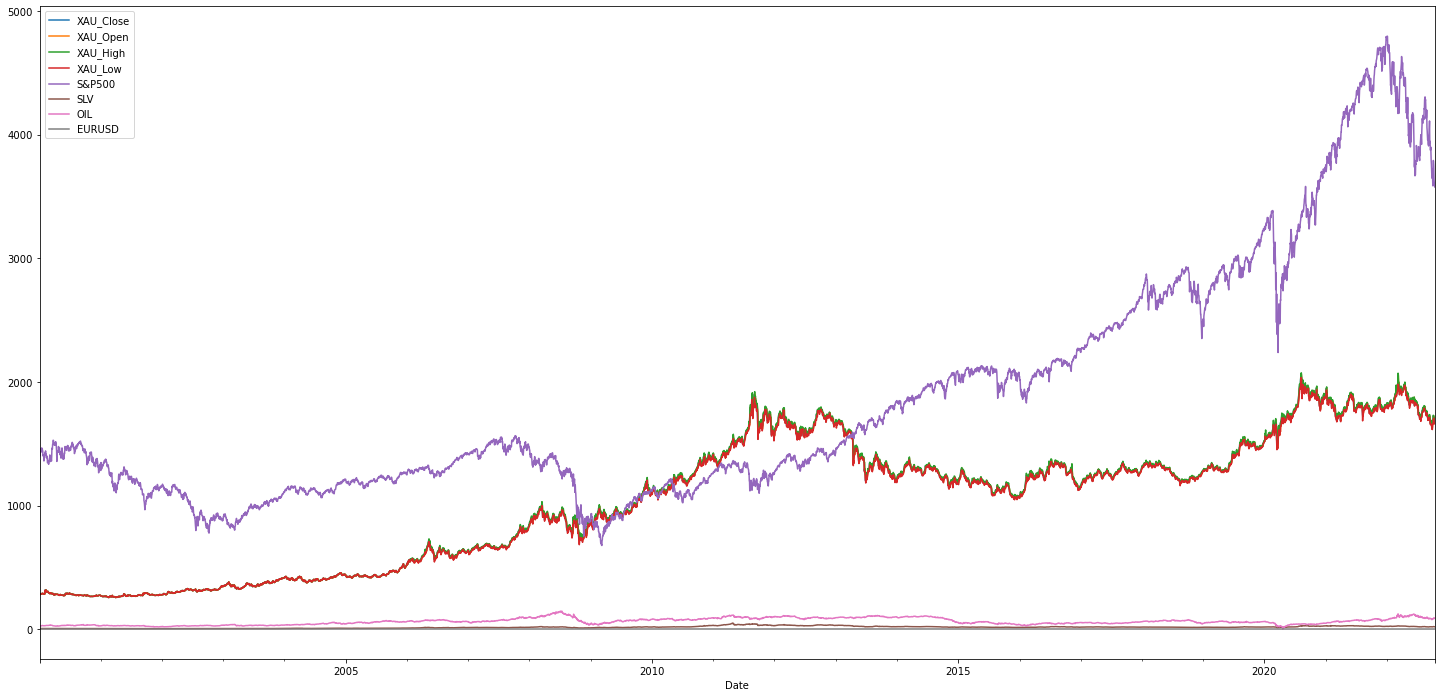

In [4]:
xau = pd.read_csv(r"C:\Users\GRACE ESTRADA\OneDrive\Desktop\XAUUSD.csv", parse_dates = ['Date'])

xau = xau.sort_values('Date', ascending = True)
xau = xau.set_index('Date')
xau[xau < 0] = 0.00001
xau = xau.asfreq('B')
xau = xau[1:].ffill()
xau.plot()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

### MODEL TUNING  [ALL VARIABLES]

In [6]:
# LAG VALUES

xau_lag = xau[['XAU_High', 'XAU_Low', 'S&P500', 'SLV', 'OIL', 'EURUSD']].shift(1)
xau_lag.insert(0, 'XAU_Close', xau['XAU_Close'])
xau_lag.insert(1, 'XAU_Open', xau['XAU_Open'])
xau_lag = xau_lag[1:]
xau_lag.rename(columns = {'XAU_High': 'XAU_High_lag1',
                          'XAU_Low': 'XAU_Low_lag1',
                          'S&P500': 'S&P500_lag1',
                          'SLV' : 'SLV_lag1',
                          'OIL': 'OIL_lag1',
                          'EURUSD': 'EURUSD_lag'}, inplace=True)

xau = xau[1:]

assert len(xau) == len(xau_lag)

In [7]:
# Define Endog and Exog Variables

endog = xau['XAU_Close']
exog = xau_lag.drop(columns = ['XAU_Close'])

endog_train = xau[['XAU_Close']]['2000-01-01':'2021-12-31']
endog_test = xau[['XAU_Close']]['2022-01-01':]

exog_train = xau_lag.drop(columns = ['XAU_Close'])['2000-01-01':'2021-12-31']
exog_test = xau_lag.drop(columns = ['XAU_Close'])['2022-01-01':]

# Create a range of all possible parameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 30

# Create a list with all possible combination of parameters
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMAX(endog_train, exog_train, parameters_list, d, D, s)
result_df

#### MODEL BUILDING

In [8]:
best_model = SARIMAX(endog_train, 
                     exog_train, 
                     order=(3,1,5), 
                     seasonal_order=(1,0,1,90),
                     simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            XAU_Close   No. Observations:                 5738
Model:             SARIMAX(3, 1, 5)x(1, 0, [1], 90)   Log Likelihood              -22289.053
Date:                              Thu, 20 Oct 2022   AIC                          44614.106
Time:                                      17:45:40   BIC                          44733.890
Sample:                                  01-05-2000   HQIC                         44655.797
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
XAU_Open          0.6521      0.061     10.766      0.000       0.533       0.771
XAU_High_l

#### MODEL EVALUATION

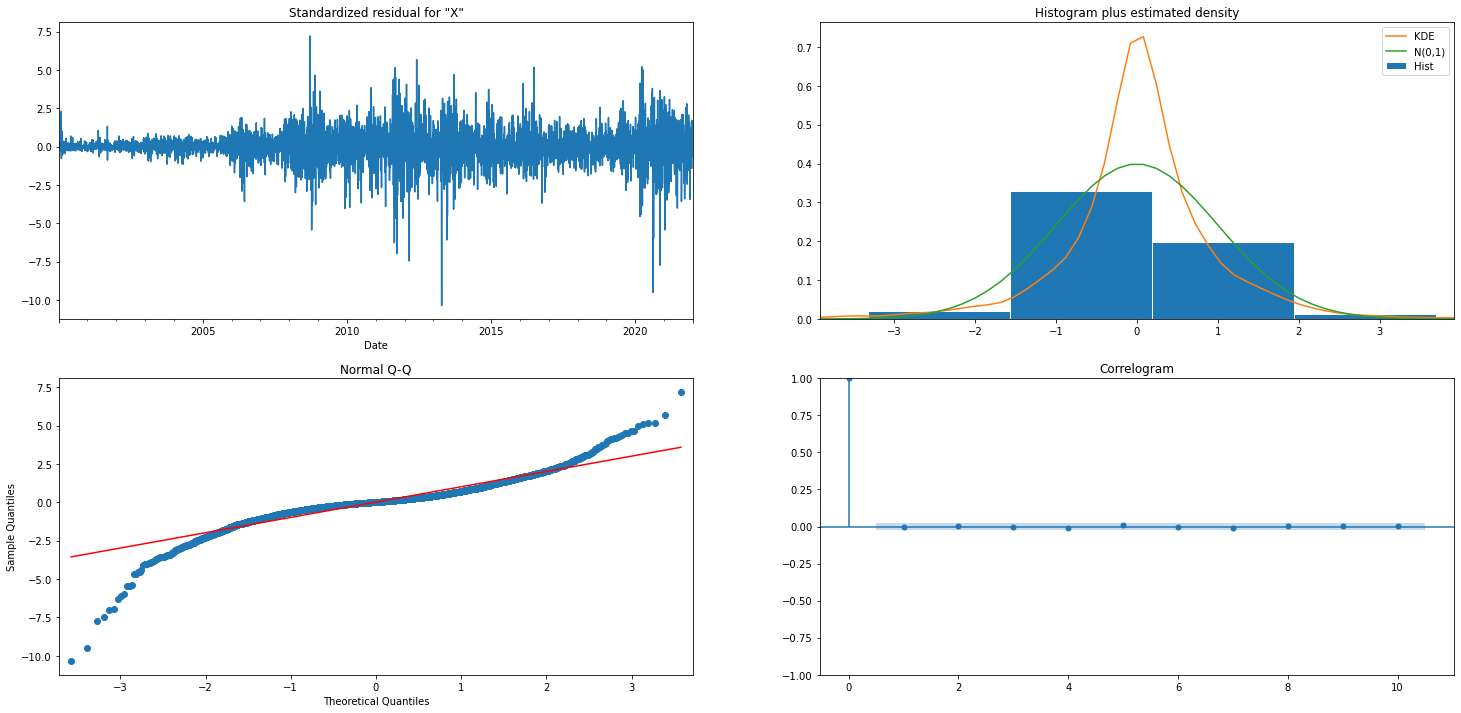

In [9]:
res.plot_diagnostics();

#### FORECASTING

In [10]:
n_forecast = len(exog_test)

predict = res.get_prediction(exog = exog_test, end=best_model.nobs + n_forecast-1, dynamic=False)
predictions = predict.predicted_mean
predictions

2000-01-05     187.520022
2000-01-06     280.482043
2000-01-07     281.630781
2000-01-10     282.570947
2000-01-11     281.968075
                 ...     
2022-10-06    1751.146899
2022-10-07    1747.090648
2022-10-10    1737.459094
2022-10-11    1720.896723
2022-10-12    1719.444237
Freq: B, Name: predicted_mean, Length: 5941, dtype: float64

In [11]:
xau_lag['Predicted'] = predictions
forecast = xau_lag[xau_lag[['Predicted']].index.isin(endog_test.index)]

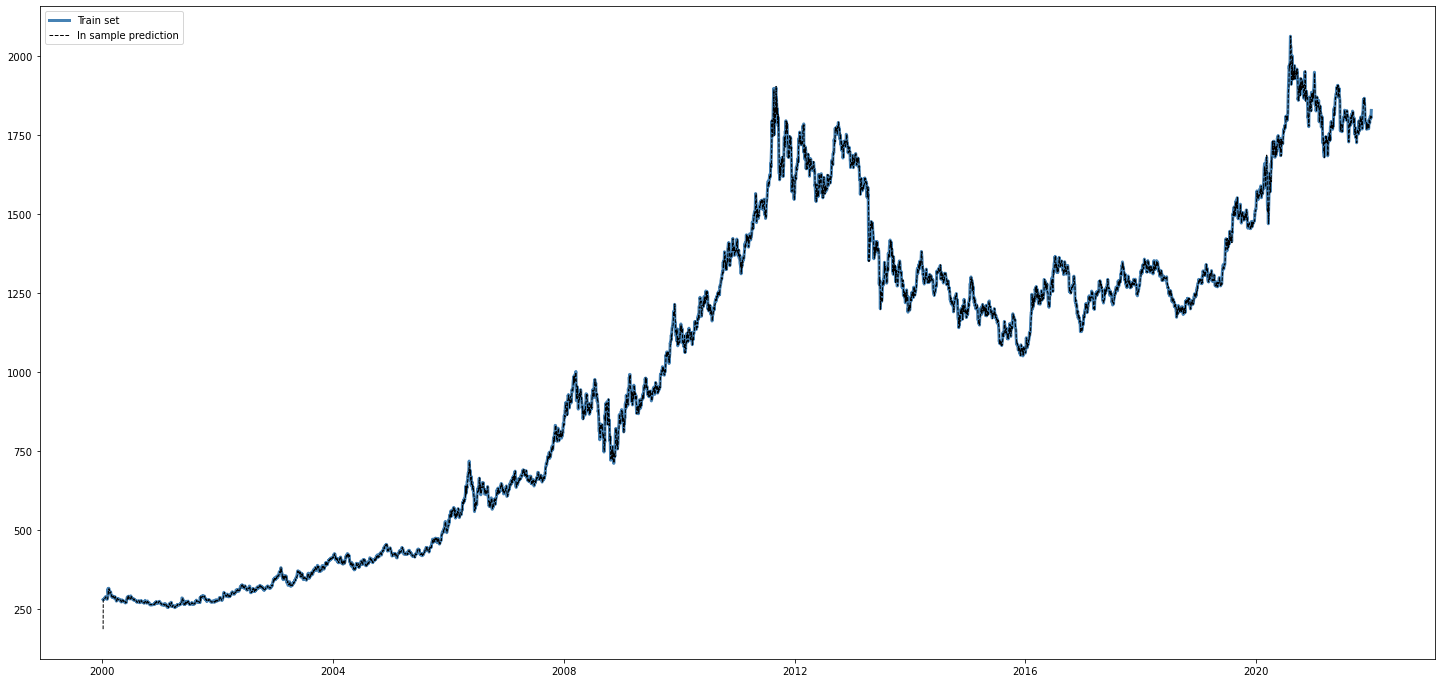

In [12]:
#In-sample SARIMAX forecast

fig, ax = plt.subplots()

ax.plot(xau['XAU_Close'][:'2021'], 'steelblue', label = 'Train set', linewidth = 3)
ax.plot(xau_lag['Predicted'][:'2021'], 'black', linestyle = 'dashed', label = 'In sample prediction', linewidth = 1)

ax.legend(loc = 'upper left')

plt.show()


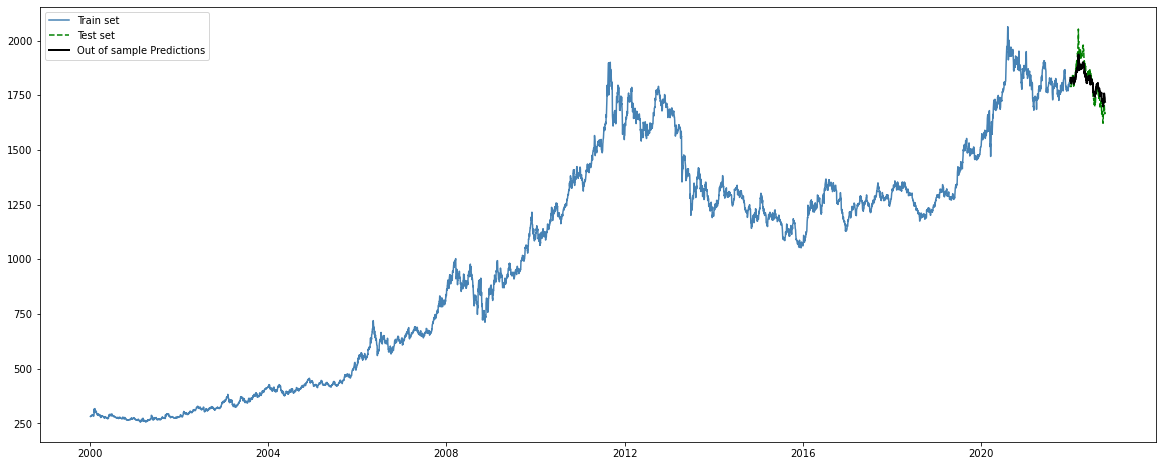

In [13]:
#Out-of-sample SARIMAX forecast (zoomed-out)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train, 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', linestyle = 'dashed', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()


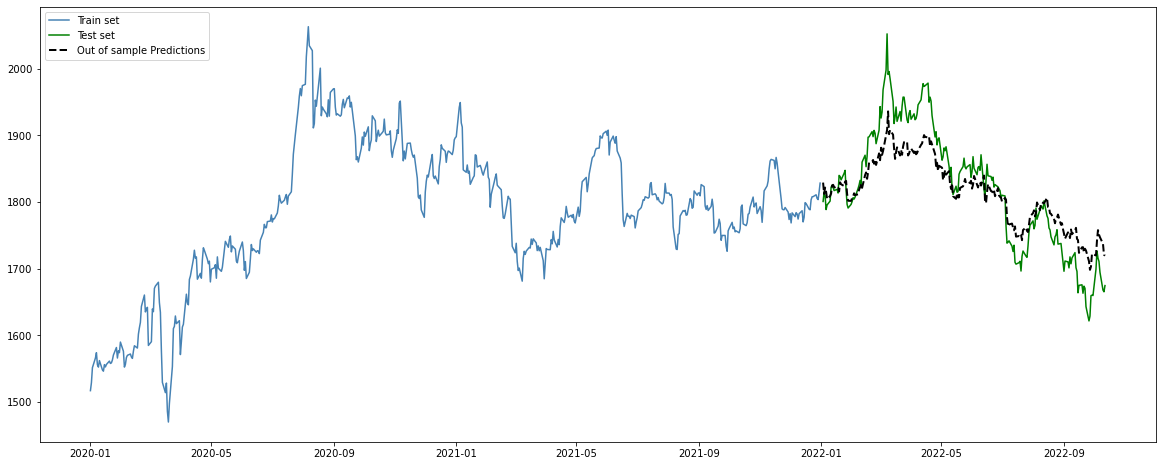

In [14]:
#Out-of-sample SARIMAX forecast (zoomed-in)
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plt.subplots()


ax.plot(endog_train['2020':], 'steelblue', label = 'Train set')
ax.plot(endog_test, 'green', label = 'Test set')
ax.plot(forecast['Predicted'], 'black', linestyle = 'dashed', linewidth = 2,label = 'Out of sample Predictions')

ax.legend(loc = 'upper left')

plt.show()

In [15]:
#RMSE
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

endog_test['Predicted'] = predict.predicted_mean

r2 = r2(endog_test['XAU_Close'], endog_test['Predicted'])
mse = mse(endog_test['XAU_Close'], endog_test['Predicted'])
rmse = np.sqrt(mse)

print(f"R2:{r2}\nMSE: {mse}\nRMSE: {rmse}")

R2:0.7786996044177243
MSE: 1811.9524668719519
RMSE: 42.567034978630495


In [17]:
# Export out-of-sample predictions to CSV
xau_lag.to_csv('SARIMAX_forecast.csv')